In [2]:
!pip install gym
!pip install keras
!pip install tensorflow

In [3]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.


In [4]:
EPISODES = 1000 
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_size):
        self.check_solve = False	#If True, stop if you satisfy solution confition
        self.render = True        #If you want to see Cartpole learning, then change to True

        #Get size of state and action
        self.state_size = state_size
        self.action_size = action_size

       # Modify here

        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.95
        self.learning_rate = 0.005
        self.epsilon = 0.02 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1

        #Number of test states for Q value plots
        self.test_state_no = 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
###############################################################################
###############################################################################

    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):
###############################################################################
###############################################################################
        #Insert your e-greedy policy code here
        #Tip 1: Use the random package to generate a random action.
        #Tip 2: Use keras.model.predict() to compute Q-values from the state.
        random_action = random.uniform(0, 1)
        if random_action < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            Q = self.model.predict(state)
            action = np.argmax(Q)
        return action
###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network

        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###############################################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        for i in range(self.batch_size): #For every batch
            target[i][action[i]] = random.randint(0,1)
            
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor*np.amax(target_val[i,:])
###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores.png")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
__________________________________

episode: 94   score: 101.0  q_value: [19.43547847]   memory length: 1000
episode: 95   score: 95.0  q_value: [19.55119385]   memory length: 1000
episode: 96   score: 99.0  q_value: [18.98626905]   memory length: 1000
episode: 97   score: 200.0  q_value: [19.85675673]   memory length: 1000
episode: 98   score: 200.0  q_value: [19.57250221]   memory length: 1000
episode: 99   score: 200.0  q_value: [19.68894086]   memory length: 1000
episode: 100   score: 156.0  q_value: [19.83326856]   memory length: 1000
episode: 101   score: 200.0  q_value: [20.40506679]   memory length: 1000
episode: 102   score: 200.0  q_value: [20.48468523]   memory length: 1000
episode: 103   score: 141.0  q_value: [20.48814173]   memory length: 1000
episode: 104   score: 112.0  q_value: [20.65588428]   memory length: 1000
episode: 105   score: 84.0  q_value: [20.82764434]   memory length: 1000
episode: 106   score: 55.0  q_value: [20.57881333]   memory length: 1000
episode: 107   score: 80.0  q_value: [20.0364025

episode: 206   score: 183.0  q_value: [18.23915098]   memory length: 1000
episode: 207   score: 200.0  q_value: [18.52699553]   memory length: 1000
episode: 208   score: 200.0  q_value: [18.43021785]   memory length: 1000
episode: 209   score: 200.0  q_value: [18.47433095]   memory length: 1000
episode: 210   score: 200.0  q_value: [18.43199927]   memory length: 1000
episode: 211   score: 200.0  q_value: [18.70942063]   memory length: 1000
episode: 212   score: 200.0  q_value: [18.70286768]   memory length: 1000
episode: 213   score: 170.0  q_value: [18.91904899]   memory length: 1000
episode: 214   score: 200.0  q_value: [19.06542438]   memory length: 1000
episode: 215   score: 200.0  q_value: [19.2866611]   memory length: 1000
episode: 216   score: 186.0  q_value: [19.31151133]   memory length: 1000
episode: 217   score: 200.0  q_value: [19.36571822]   memory length: 1000
episode: 218   score: 200.0  q_value: [19.25938071]   memory length: 1000
episode: 219   score: 200.0  q_value: [

episode: 318   score: 200.0  q_value: [18.74044226]   memory length: 1000
episode: 319   score: 200.0  q_value: [18.8575974]   memory length: 1000
episode: 320   score: 200.0  q_value: [18.75547436]   memory length: 1000
episode: 321   score: 170.0  q_value: [18.59393086]   memory length: 1000
episode: 322   score: 25.0  q_value: [17.96264956]   memory length: 1000
episode: 323   score: 146.0  q_value: [17.66058899]   memory length: 1000
episode: 324   score: 200.0  q_value: [17.68917492]   memory length: 1000
episode: 325   score: 199.0  q_value: [17.69683728]   memory length: 1000
episode: 326   score: 200.0  q_value: [17.95442735]   memory length: 1000
episode: 327   score: 200.0  q_value: [18.2513582]   memory length: 1000
episode: 328   score: 200.0  q_value: [18.20379345]   memory length: 1000
episode: 329   score: 200.0  q_value: [18.2684662]   memory length: 1000
episode: 330   score: 200.0  q_value: [18.20803699]   memory length: 1000
episode: 331   score: 200.0  q_value: [18.

episode: 430   score: 200.0  q_value: [18.30814388]   memory length: 1000
episode: 431   score: 200.0  q_value: [18.70265237]   memory length: 1000
episode: 432   score: 200.0  q_value: [18.38839654]   memory length: 1000
episode: 433   score: 181.0  q_value: [17.85740391]   memory length: 1000
episode: 434   score: 102.0  q_value: [17.8445585]   memory length: 1000
episode: 435   score: 200.0  q_value: [17.10065619]   memory length: 1000
episode: 436   score: 200.0  q_value: [16.97307534]   memory length: 1000
episode: 437   score: 200.0  q_value: [17.46868822]   memory length: 1000
episode: 438   score: 194.0  q_value: [17.53287563]   memory length: 1000
episode: 439   score: 200.0  q_value: [17.40238019]   memory length: 1000
episode: 440   score: 200.0  q_value: [17.04260423]   memory length: 1000
episode: 441   score: 191.0  q_value: [17.62847062]   memory length: 1000
episode: 442   score: 200.0  q_value: [18.07282715]   memory length: 1000
episode: 443   score: 200.0  q_value: [

episode: 542   score: 23.0  q_value: [19.00728013]   memory length: 1000
episode: 543   score: 74.0  q_value: [19.07926367]   memory length: 1000
episode: 544   score: 53.0  q_value: [19.31734669]   memory length: 1000
episode: 545   score: 153.0  q_value: [19.42000519]   memory length: 1000
episode: 546   score: 73.0  q_value: [19.30854411]   memory length: 1000
episode: 547   score: 83.0  q_value: [19.31912923]   memory length: 1000
episode: 548   score: 155.0  q_value: [19.26095727]   memory length: 1000
episode: 549   score: 94.0  q_value: [18.71292448]   memory length: 1000
episode: 550   score: 200.0  q_value: [18.91775045]   memory length: 1000
episode: 551   score: 200.0  q_value: [19.02267805]   memory length: 1000
episode: 552   score: 200.0  q_value: [18.82447014]   memory length: 1000
episode: 553   score: 200.0  q_value: [18.73383691]   memory length: 1000
episode: 554   score: 62.0  q_value: [19.127933]   memory length: 1000
episode: 555   score: 59.0  q_value: [19.176744

episode: 654   score: 12.0  q_value: [18.3976591]   memory length: 1000
episode: 655   score: 200.0  q_value: [18.4061765]   memory length: 1000
episode: 656   score: 189.0  q_value: [18.29859738]   memory length: 1000
episode: 657   score: 200.0  q_value: [18.27740459]   memory length: 1000
episode: 658   score: 200.0  q_value: [18.33695589]   memory length: 1000
episode: 659   score: 137.0  q_value: [18.45975909]   memory length: 1000
episode: 660   score: 199.0  q_value: [18.36878357]   memory length: 1000
episode: 661   score: 200.0  q_value: [18.70249016]   memory length: 1000
episode: 662   score: 61.0  q_value: [18.99851391]   memory length: 1000
episode: 663   score: 200.0  q_value: [18.92005775]   memory length: 1000
episode: 664   score: 125.0  q_value: [18.9462442]   memory length: 1000
episode: 665   score: 95.0  q_value: [19.20344618]   memory length: 1000
episode: 666   score: 36.0  q_value: [18.99117682]   memory length: 1000
episode: 667   score: 101.0  q_value: [19.186

episode: 766   score: 200.0  q_value: [18.46004471]   memory length: 1000
episode: 767   score: 200.0  q_value: [18.34396444]   memory length: 1000
episode: 768   score: 194.0  q_value: [18.54996422]   memory length: 1000
episode: 769   score: 194.0  q_value: [18.78181154]   memory length: 1000
episode: 770   score: 78.0  q_value: [18.65787507]   memory length: 1000
episode: 771   score: 158.0  q_value: [18.83991168]   memory length: 1000
episode: 772   score: 200.0  q_value: [18.77965046]   memory length: 1000
episode: 773   score: 124.0  q_value: [18.57774965]   memory length: 1000
episode: 774   score: 123.0  q_value: [18.70510279]   memory length: 1000
episode: 775   score: 15.0  q_value: [18.85340881]   memory length: 1000
episode: 776   score: 43.0  q_value: [19.17680714]   memory length: 1000
episode: 777   score: 30.0  q_value: [19.08670447]   memory length: 1000
episode: 778   score: 12.0  q_value: [19.16767132]   memory length: 1000
episode: 779   score: 18.0  q_value: [19.01

episode: 878   score: 200.0  q_value: [18.54000081]   memory length: 1000
episode: 879   score: 200.0  q_value: [18.67354723]   memory length: 1000
episode: 880   score: 51.0  q_value: [18.44607104]   memory length: 1000
episode: 881   score: 200.0  q_value: [18.53323164]   memory length: 1000
episode: 882   score: 200.0  q_value: [18.17925371]   memory length: 1000
episode: 883   score: 200.0  q_value: [17.97956762]   memory length: 1000
episode: 884   score: 200.0  q_value: [17.9612542]   memory length: 1000
episode: 885   score: 193.0  q_value: [18.03219744]   memory length: 1000
episode: 886   score: 177.0  q_value: [18.28933303]   memory length: 1000
episode: 887   score: 199.0  q_value: [18.55745102]   memory length: 1000
episode: 888   score: 200.0  q_value: [18.93792847]   memory length: 1000
episode: 889   score: 43.0  q_value: [19.09359434]   memory length: 1000
episode: 890   score: 93.0  q_value: [19.29783965]   memory length: 1000
episode: 891   score: 116.0  q_value: [19.

episode: 990   score: 200.0  q_value: [19.02640541]   memory length: 1000
episode: 991   score: 13.0  q_value: [18.97542677]   memory length: 1000
episode: 992   score: 106.0  q_value: [19.07578013]   memory length: 1000
episode: 993   score: 200.0  q_value: [19.15116297]   memory length: 1000
episode: 994   score: 171.0  q_value: [19.20897946]   memory length: 1000
episode: 995   score: 160.0  q_value: [19.11923082]   memory length: 1000
episode: 996   score: 135.0  q_value: [19.23051066]   memory length: 1000
episode: 997   score: 163.0  q_value: [19.06403164]   memory length: 1000
episode: 998   score: 161.0  q_value: [18.87533449]   memory length: 1000
episode: 999   score: 200.0  q_value: [18.69342598]   memory length: 1000


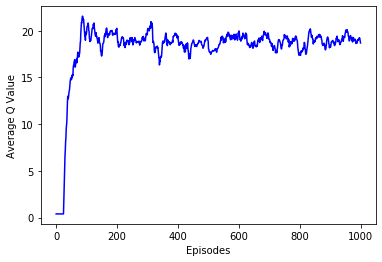

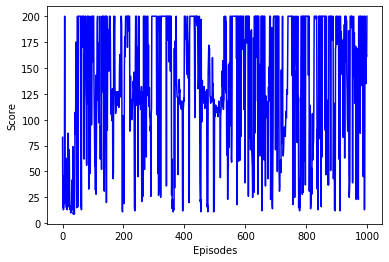

In [5]:
env = gym.make('CartPole-v0') #Generate Cartpole-v0 environment object from the gym library
#Get state and action sizes from the environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#Create agent, see the DQNAgent __init__ method for details
agent = DQNAgent(state_size, action_size)

#Collect test states for plotting Q values using uniform random policy
test_states = np.zeros((agent.test_state_no, state_size))
max_q = np.zeros((EPISODES, agent.test_state_no))
max_q_mean = np.zeros((EPISODES,1))

done = True
for i in range(agent.test_state_no):
    if done:
        done = False
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        test_states[i] = state
    else:
        action = random.randrange(action_size)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        test_states[i] = state
        state = next_state

scores, episodes = [], [] #Create dynamically growing score and episode counters
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset() #Initialize/reset the environment
    state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
    #Compute Q values for plotting
    tmp = agent.model.predict(test_states)
    max_q[e][:] = np.max(tmp, axis=1)
    max_q_mean[e] = np.mean(max_q[e][:])

    while not done:
        if agent.render:
            env.render() #Show cartpole animation

        #Get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state

        #Save sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        #Training step
        agent.train_model()
        score += reward #Store episodic reward
        state = next_state #Propagate state

        if done:
            #At the end of very episode, update the target network
            if e % agent.target_update_frequency == 0:
                agent.update_target_model()
            #Plot the play time for every episode
            scores.append(score)
            episodes.append(e)

            print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",
                  len(agent.memory))

            # if the mean of scores of last 100 episodes is bigger than 195
            # stop training
            if agent.check_solve:
                if np.mean(scores[-min(100, len(scores)):]) >= 195:
                    print("solved after", e-100, "episodes")
                    agent.plot_data(episodes,scores,max_q_mean[:e+1])
                    sys.exit()
agent.plot_data(episodes,scores,max_q_mean)

In [ ]:
random_action = np.random.random()
random_action

In [15]:
random.uniform(0, 1)

0.3289263272002467

In [20]:
random.randrange(5)

1

In [38]:
a = [[1,20,3],[4,15,6]]
z = np.argmax(a, axis=1)

In [39]:
z

array([1, 1], dtype=int64)

In [44]:
env = gym.make('CartPole-v0') #Generate Cartpole-v0 environment object from the gym library
#Get state and action sizes from the environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n